# Posture detection keras model

## 1 Engineer features

### 1.1 Import libraries and define transformers  

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from keras.utils import to_categorical
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
__file__ = 'drone_pos_model_christian.ipynb'

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x

In [21]:
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x

In [22]:
class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x

In [23]:
class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x

### 1.2  Inspect data

In [24]:
path = "posture_training_data"
df = pd.read_csv("../data/"+ path + ".csv",low_memory=False)
df = df.dropna().drop_duplicates()
print(df.shape)
df.head()

(1867, 13)


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,364.388477,175.727292,326.376146,176.318343,373.932203,185.283770,323.401138,178.613052,363.882516,247.058341,335.419796,245.791503,2
9,362.043733,162.669425,322.806684,162.934143,368.892477,106.262375,314.567677,103.431298,360.476755,244.545429,332.341002,246.078227,0
10,361.398062,161.761029,319.718081,157.452745,359.997208,94.588426,315.145723,95.310308,358.496267,245.388146,332.033283,245.604833,0
11,356.940976,156.356530,317.715580,160.940937,355.271911,92.585746,315.198539,95.782529,355.675736,241.225170,332.092374,243.839404,0
12,355.355181,159.860870,319.357292,159.059428,355.228806,95.781997,315.496033,96.264859,355.045702,243.383177,330.646016,244.469512,0


In [25]:
assert df.isnull().all().all() == False

### 1.3 Set pipeline arguments

In [26]:
x_cols = ['leftShoulder_x', 'rightShoulder_x', 'leftWrist_x', 'rightWrist_x', 'leftHip_x' ,'rightHip_x']
y_cols = list(set(df.columns)-set(x_cols))

### 1.4 Build data processing pipeline

In [27]:
processing_pipeline = make_pipeline(XCentralizer(x_cols), YCentralizer(y_cols), YScaler(), Shuffler())
processed_df = processing_pipeline.fit_transform(df)
processed_df.head()

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
915,2.722892,-0.504198,2.182960,-0.495802,2.858452,-0.368456,2.140703,-0.463208,2.715705,0.508997,2.311417,0.491003,2
1482,2.312823,-0.501604,1.837280,-0.498396,2.395828,-1.185243,1.737426,-1.219555,2.293832,0.490711,1.952834,0.509289,0
1495,2.225171,-0.474920,1.739897,-0.525080,2.208861,-1.257000,1.686662,-1.248596,2.191386,0.498739,1.883281,0.501261,0
605,2.244502,-0.527326,1.776885,-0.472674,2.224605,-1.287556,1.746879,-1.249446,2.229419,0.484417,1.948275,0.515583,0
499,2.210080,-0.495256,1.783899,-0.504744,2.208584,-1.253889,1.738185,-1.248173,2.206416,0.493569,1.917547,0.506431,0


In [28]:
assert df.shape[0] == processed_df.shape[0]

## 2 Train model

### 2.1  Split in train / test

In [29]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_test = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [31]:
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

### 2.2 Define numpy arrays as needed by model

In [34]:
x_train = df_train.drop(['label'], axis=1).values
y_train = df_train['label'].values

x_test = df_test.drop(['label'], axis=1).values
y_test = df_test['label'].values

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
print(x_train.shape, y_train.shape )
print("x_train[0]=", x_train[0],"\n y_train[0]=", y_train[0])

(1493, 12) (1493, 6)
x_train[0]= [ 2.72289192 -0.50419768  2.18296018 -0.49580232  2.85845216 -0.36845632
  2.14070281 -0.463208    2.7157052   0.50899717  2.31141728  0.49100283] 
 y_train[0]= [0. 0. 1. 0. 0. 0.]


### 2.3 Define and compile model

In [39]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics

model = models.Sequential()
model.add(layers.Dense(20, activation="relu", input_shape=(12, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(6, activation="softmax")) 
model.summary()   

model.compile(optimizer=optimizers.RMSprop(lr=0.005),
              loss=losses.categorical_crossentropy,
              metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                260       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 96        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


### 2.4 Fit and validate model

In [40]:
history = model.fit(x_train, y_train, epochs=2000, batch_size=30, validation_split=0.2)

Train on 1194 samples, validate on 299 samples
Epoch 1/2000
1194/1194 [==============================] - 1s 470us/step - loss: 1.1874 - acc: 0.6750 - val_loss: 0.8148 - val_acc: 0.8094
Epoch 2/2000
1194/1194 [==============================] - 0s 61us/step - loss: 0.3966 - acc: 0.9489 - val_loss: 0.2840 - val_acc: 0.9967
Epoch 3/2000
1194/1194 [==============================] - 0s 64us/step - loss: 0.1078 - acc: 1.0000 - val_loss: 0.0665 - val_acc: 1.0000
Epoch 4/2000
1194/1194 [==============================] - 0s 78us/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.0380 - val_acc: 0.9900
Epoch 5/2000
1194/1194 [==============================] - 0s 69us/step - loss: 0.0108 - acc: 0.9992 - val_loss: 0.0100 - val_acc: 0.9967
Epoch 6/2000
1194/1194 [==============================] - 0s 69us/step - loss: 0.0064 - acc: 0.9992 - val_loss: 0.0074 - val_acc: 0.9967
Epoch 7/2000
1194/1194 [==============================] - 0s 66us/step - loss: 0.0092 - acc: 0.9966 - val_loss: 0.0072 - val_acc: 

Epoch 59/2000
1194/1194 [==============================] - 0s 59us/step - loss: 5.5788e-05 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9967
Epoch 60/2000
1194/1194 [==============================] - 0s 52us/step - loss: 0.0016 - acc: 0.9992 - val_loss: 5.0900e-04 - val_acc: 1.0000
Epoch 61/2000
1194/1194 [==============================] - 0s 45us/step - loss: 9.4024e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 62/2000
1194/1194 [==============================] - 0s 64us/step - loss: 2.8827e-04 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9799
Epoch 63/2000
1194/1194 [==============================] - 0s 52us/step - loss: 0.0016 - acc: 0.9992 - val_loss: 0.0027 - val_acc: 0.9967
Epoch 64/2000
1194/1194 [==============================] - 0s 54us/step - loss: 0.0033 - acc: 0.9983 - val_loss: 0.0144 - val_acc: 0.9967
Epoch 65/2000
1194/1194 [==============================] - 0s 54us/step - loss: 0.0021 - acc: 0.9992 - val_loss: 0.0119 - val_acc: 0.9967
Epoch 66/2000
1194

Epoch 117/2000
1194/1194 [==============================] - 0s 81us/step - loss: 5.6296e-05 - acc: 1.0000 - val_loss: 3.6839e-04 - val_acc: 1.0000
Epoch 118/2000
1194/1194 [==============================] - 0s 110us/step - loss: 5.7580e-05 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9967
Epoch 119/2000
1194/1194 [==============================] - 0s 99us/step - loss: 1.5740e-04 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9967
Epoch 120/2000
1194/1194 [==============================] - 0s 88us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0180 - val_acc: 0.9967
Epoch 121/2000
1194/1194 [==============================] - 0s 86us/step - loss: 1.2020e-04 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9967
Epoch 122/2000
1194/1194 [==============================] - 0s 99us/step - loss: 1.6570e-04 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9967
Epoch 123/2000
1194/1194 [==============================] - 0s 92us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0243 - val_acc: 0.9967
Ep

1194/1194 [==============================] - 0s 61us/step - loss: 3.3299e-06 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 0.9967
Epoch 174/2000
1194/1194 [==============================] - 0s 62us/step - loss: 3.6029e-07 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 0.9967
Epoch 175/2000
1194/1194 [==============================] - 0s 59us/step - loss: 9.0325e-04 - acc: 0.9992 - val_loss: 0.0152 - val_acc: 0.9967
Epoch 176/2000
1194/1194 [==============================] - 0s 59us/step - loss: 3.0639e-06 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9967
Epoch 177/2000
1194/1194 [==============================] - 0s 63us/step - loss: 2.2484e-06 - acc: 1.0000 - val_loss: 2.6386e-04 - val_acc: 1.0000
Epoch 178/2000
1194/1194 [==============================] - 0s 48us/step - loss: 1.2179e-06 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9967
Epoch 179/2000
1194/1194 [==============================] - 0s 65us/step - loss: 0.0043 - acc: 0.9992 - val_loss: 0.0128 - val_acc: 0.9967
Epoch 180/2000

1194/1194 [==============================] - 0s 60us/step - loss: 2.0493e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9967
Epoch 231/2000
1194/1194 [==============================] - 0s 60us/step - loss: 2.9469e-06 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9967
Epoch 232/2000
1194/1194 [==============================] - 0s 51us/step - loss: 4.7022e-07 - acc: 1.0000 - val_loss: 7.0120e-06 - val_acc: 1.0000
Epoch 233/2000
1194/1194 [==============================] - 0s 66us/step - loss: 4.0605e-06 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9967
Epoch 234/2000
1194/1194 [==============================] - 0s 53us/step - loss: 4.8868e-05 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9967
Epoch 235/2000
1194/1194 [==============================] - 0s 74us/step - loss: 6.9368e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 236/2000
1194/1194 [==============================] - 0s 76us/step - loss: 1.6399e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 0.9967
Epoch 237/

1194/1194 [==============================] - 0s 66us/step - loss: 1.7403e-04 - acc: 1.0000 - val_loss: 2.0134e-05 - val_acc: 1.0000
Epoch 288/2000
1194/1194 [==============================] - 0s 61us/step - loss: 0.0013 - acc: 0.9992 - val_loss: 0.0511 - val_acc: 0.9967
Epoch 289/2000
1194/1194 [==============================] - 0s 56us/step - loss: 1.8010e-04 - acc: 1.0000 - val_loss: 5.9397e-05 - val_acc: 1.0000
Epoch 290/2000
1194/1194 [==============================] - 0s 56us/step - loss: 2.2125e-07 - acc: 1.0000 - val_loss: 7.1973e-05 - val_acc: 1.0000
Epoch 291/2000
1194/1194 [==============================] - 0s 57us/step - loss: 1.8201e-07 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 292/2000
1194/1194 [==============================] - 0s 51us/step - loss: 1.2854e-07 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 293/2000
1194/1194 [==============================] - 0s 72us/step - loss: 7.5539e-07 - acc: 1.0000 - val_loss: 1.1622e-05 - val_acc: 1.0000
Ep

1194/1194 [==============================] - 0s 118us/step - loss: 1.1971e-07 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 0.9967
Epoch 345/2000
1194/1194 [==============================] - 0s 123us/step - loss: 1.2111e-07 - acc: 1.0000 - val_loss: 2.8415e-04 - val_acc: 1.0000
Epoch 346/2000
1194/1194 [==============================] - 0s 127us/step - loss: 1.2540e-07 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9967
Epoch 347/2000
1194/1194 [==============================] - 0s 129us/step - loss: 1.0160e-06 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 0.9967
Epoch 348/2000
1194/1194 [==============================] - 0s 128us/step - loss: 6.7374e-04 - acc: 0.9992 - val_loss: 0.0515 - val_acc: 0.9967
Epoch 349/2000
1194/1194 [==============================] - 0s 168us/step - loss: 3.6551e-05 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9967
Epoch 350/2000
1194/1194 [==============================] - 0s 143us/step - loss: 2.3211e-06 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9967
Epo

1194/1194 [==============================] - 0s 119us/step - loss: 1.4387e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 0.9967
Epoch 401/2000
1194/1194 [==============================] - 0s 121us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 0.9967
Epoch 402/2000
1194/1194 [==============================] - 0s 124us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9967
Epoch 403/2000
1194/1194 [==============================] - 0s 167us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.5165e-05 - val_acc: 1.0000
Epoch 404/2000
1194/1194 [==============================] - 0s 177us/step - loss: 0.0015 - acc: 0.9992 - val_loss: 3.3015e-06 - val_acc: 1.0000
Epoch 405/2000
1194/1194 [==============================] - 0s 173us/step - loss: 2.2398e-05 - acc: 1.0000 - val_loss: 3.4639e-06 - val_acc: 1.0000
Epoch 406/2000
1194/1194 [==============================] - 0s 157us/step - loss: 3.7972e-07 - acc: 1.0000 - val_loss: 4.7111e-06 - val_acc: 1.

1194/1194 [==============================] - 0s 120us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 457/2000
1194/1194 [==============================] - 0s 126us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 458/2000
1194/1194 [==============================] - 0s 111us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 459/2000
1194/1194 [==============================] - 0s 137us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 460/2000
1194/1194 [==============================] - 0s 168us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 461/2000
1194/1194 [==============================] - 0s 167us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 462/2000
1194/1194 [==============================] - 0s 152us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 4

Epoch 513/2000
1194/1194 [==============================] - 0s 113us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 514/2000
1194/1194 [==============================] - 0s 85us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 515/2000
1194/1194 [==============================] - 0s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 516/2000
1194/1194 [==============================] - 0s 73us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 517/2000
1194/1194 [==============================] - 0s 74us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 518/2000
1194/1194 [==============================] - 0s 97us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 519/2000
1194/1194 [==============================] - 0s 94us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.996

1194/1194 [==============================] - 0s 186us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 570/2000
1194/1194 [==============================] - 0s 173us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 571/2000
1194/1194 [==============================] - 0s 160us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 572/2000
1194/1194 [==============================] - 0s 152us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 573/2000
1194/1194 [==============================] - 0s 171us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 574/2000
1194/1194 [==============================] - 0s 175us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 575/2000
1194/1194 [==============================] - 0s 171us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 5

Epoch 626/2000
1194/1194 [==============================] - 0s 171us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 627/2000
1194/1194 [==============================] - 0s 175us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 628/2000
1194/1194 [==============================] - 0s 188us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 629/2000
1194/1194 [==============================] - 0s 183us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 630/2000
1194/1194 [==============================] - 0s 181us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 631/2000
1194/1194 [==============================] - 0s 183us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 632/2000
1194/1194 [==============================] - 0s 181us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

Epoch 683/2000
1194/1194 [==============================] - 0s 146us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 684/2000
1194/1194 [==============================] - 0s 201us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 685/2000
1194/1194 [==============================] - 0s 159us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 686/2000
1194/1194 [==============================] - 0s 194us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 687/2000
1194/1194 [==============================] - 0s 138us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 688/2000
1194/1194 [==============================] - 0s 137us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 689/2000
1194/1194 [==============================] - 0s 127us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 740/2000
1194/1194 [==============================] - 0s 125us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 741/2000
1194/1194 [==============================] - 0s 104us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 742/2000
1194/1194 [==============================] - 0s 107us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 743/2000
1194/1194 [==============================] - 0s 117us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 744/2000
1194/1194 [==============================] - 0s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 745/2000
1194/1194 [==============================] - 0s 126us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 7

Epoch 796/2000
1194/1194 [==============================] - 0s 180us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 797/2000
1194/1194 [==============================] - 0s 134us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 798/2000
1194/1194 [==============================] - 0s 165us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 799/2000
1194/1194 [==============================] - 0s 163us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 800/2000
1194/1194 [==============================] - 0s 158us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 801/2000
1194/1194 [==============================] - 0s 157us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 802/2000
1194/1194 [==============================] - 0s 159us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

1194/1194 [==============================] - 0s 170us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 853/2000
1194/1194 [==============================] - 0s 189us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 854/2000
1194/1194 [==============================] - 0s 162us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 855/2000
1194/1194 [==============================] - 0s 168us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 856/2000
1194/1194 [==============================] - 0s 168us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 857/2000
1194/1194 [==============================] - 0s 145us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 858/2000
1194/1194 [==============================] - 0s 196us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 8

Epoch 909/2000
1194/1194 [==============================] - 0s 189us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 910/2000
1194/1194 [==============================] - 0s 229us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 911/2000
1194/1194 [==============================] - 0s 172us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 912/2000
1194/1194 [==============================] - 0s 165us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 913/2000
1194/1194 [==============================] - 0s 187us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 914/2000
1194/1194 [==============================] - 0s 171us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 915/2000
1194/1194 [==============================] - 0s 199us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

1194/1194 [==============================] - 0s 172us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 966/2000
1194/1194 [==============================] - 0s 195us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 967/2000
1194/1194 [==============================] - 0s 167us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 968/2000
1194/1194 [==============================] - ETA: 0s - loss: 1.1921e-07 - acc: 1.000 - 0s 202us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 969/2000
1194/1194 [==============================] - 0s 228us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 970/2000
1194/1194 [==============================] - 0s 193us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 971/2000
1194/1194 [==============================] - 0s 190us/step - loss: 1.1921e-07 - acc: 1.0000 - 

Epoch 1021/2000
1194/1194 [==============================] - 0s 172us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1022/2000
1194/1194 [==============================] - 0s 199us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1023/2000
1194/1194 [==============================] - 0s 215us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1024/2000
1194/1194 [==============================] - 0s 199us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1025/2000
1194/1194 [==============================] - 0s 189us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1026/2000
1194/1194 [==============================] - 0s 194us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1027/2000
1194/1194 [==============================] - 0s 206us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - v

1194/1194 [==============================] - 0s 173us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1078/2000
1194/1194 [==============================] - 0s 160us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1079/2000
1194/1194 [==============================] - 0s 162us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1080/2000
1194/1194 [==============================] - 0s 162us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1081/2000
1194/1194 [==============================] - 0s 162us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1082/2000
1194/1194 [==============================] - 0s 161us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1083/2000
1194/1194 [==============================] - 0s 160us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
E

1194/1194 [==============================] - 0s 126us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1134/2000
1194/1194 [==============================] - 0s 126us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1135/2000
1194/1194 [==============================] - 0s 134us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1136/2000
1194/1194 [==============================] - 0s 134us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1137/2000
1194/1194 [==============================] - 0s 105us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1138/2000
1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1139/2000
1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
E

1194/1194 [==============================] - 0s 142us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1190/2000
1194/1194 [==============================] - 0s 126us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1191/2000
1194/1194 [==============================] - 0s 134us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1192/2000
1194/1194 [==============================] - 0s 133us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1193/2000
1194/1194 [==============================] - 0s 127us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1194/2000
1194/1194 [==============================] - 0s 125us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1195/2000
1194/1194 [==============================] - 0s 142us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
E

Epoch 1246/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1247/2000
1194/1194 [==============================] - ETA: 0s - loss: 1.1921e-07 - acc: 1.000 - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1248/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1249/2000
1194/1194 [==============================] - 0s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1250/2000
1194/1194 [==============================] - 0s 85us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1251/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1252/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 -

1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1303/2000
1194/1194 [==============================] - 0s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1304/2000
1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1305/2000
1194/1194 [==============================] - 0s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1306/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1307/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1308/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 

Epoch 1359/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1360/2000
1194/1194 [==============================] - 0s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1361/2000
1194/1194 [==============================] - 0s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1362/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1363/2000
1194/1194 [==============================] - 0s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1364/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1365/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

1194/1194 [==============================] - 0s 42us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1416/2000
1194/1194 [==============================] - 0s 42us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1417/2000
1194/1194 [==============================] - 0s 54us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1418/2000
1194/1194 [==============================] - 0s 45us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1419/2000
1194/1194 [==============================] - 0s 43us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1420/2000
1194/1194 [==============================] - 0s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1421/2000
1194/1194 [==============================] - 0s 73us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 14

1194/1194 [==============================] - 0s 91us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1472/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1473/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1474/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1475/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1476/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1477/2000
1194/1194 [==============================] - 0s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 14

Epoch 1528/2000
1194/1194 [==============================] - 0s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1529/2000
1194/1194 [==============================] - 0s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1530/2000
1194/1194 [==============================] - 0s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1531/2000
1194/1194 [==============================] - 0s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1532/2000
1194/1194 [==============================] - 0s 91us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1533/2000
1194/1194 [==============================] - 0s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1534/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_a

Epoch 1585/2000
1194/1194 [==============================] - 0s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1586/2000
1194/1194 [==============================] - 0s 85us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1587/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1588/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1589/2000
1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1590/2000
1194/1194 [==============================] - 0s 117us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1591/2000
1194/1194 [==============================] - 0s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_a

1194/1194 [==============================] - 0s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1642/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1643/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1644/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1645/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1646/2000
1194/1194 [==============================] - 0s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1647/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1

Epoch 1698/2000
1194/1194 [==============================] - 0s 97us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1699/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1700/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1701/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1702/2000
1194/1194 [==============================] - 0s 74us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1703/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1704/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

Epoch 1755/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1756/2000
1194/1194 [==============================] - 0s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1757/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1758/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1759/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1760/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1761/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc

Epoch 1812/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1813/2000
1194/1194 [==============================] - 0s 86us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1814/2000
1194/1194 [==============================] - 0s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1815/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1816/2000
1194/1194 [==============================] - 0s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1817/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1818/2000
1194/1194 [==============================] - 0s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

1194/1194 [==============================] - 0s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1869/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1870/2000
1194/1194 [==============================] - 0s 117us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1871/2000
1194/1194 [==============================] - 0s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1872/2000
1194/1194 [==============================] - 0s 117us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1873/2000
1194/1194 [==============================] - 0s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1874/2000
1194/1194 [==============================] - 0s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epo

Epoch 1925/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1926/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1927/2000
1194/1194 [==============================] - 0s 83us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1928/2000
1194/1194 [==============================] - 0s 78us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1929/2000
1194/1194 [==============================] - 0s 74us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1930/2000
1194/1194 [==============================] - 0s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1931/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

Epoch 1982/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1983/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1984/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1985/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1986/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1987/2000
1194/1194 [==============================] - 0s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9967
Epoch 1988/2000
1194/1194 [==============================] - 0s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc:

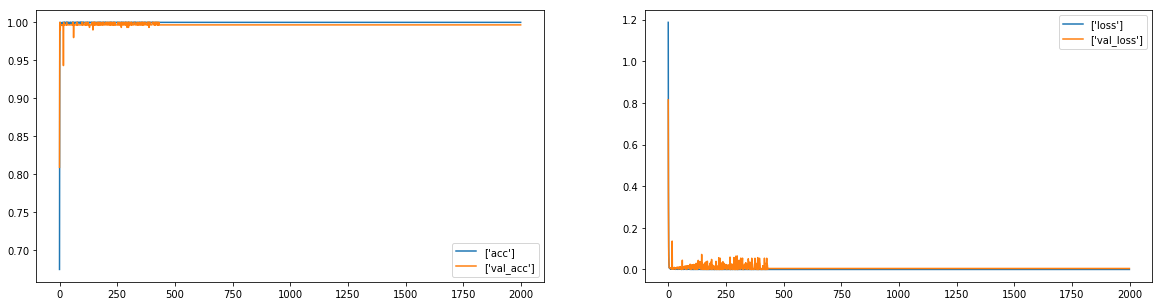

In [41]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["acc"],  label=["acc"])
plt.plot(history.history['val_acc'], label=["val_acc"])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label=["loss"]) 
plt.plot(history.history['val_loss'], label=["val_loss"])
plt.legend()

plt.show()
plt.close()

###  2.5 Evaluate with test data

In [42]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

374/374 [==============================] - 0s 53us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.0
Accuracy: 1.0


In [44]:
y_tes_pred = model.predict(x_test)

In [45]:
y_tes_pred[10]

array([1.0000000e+00, 9.5561391e-36, 1.3369655e-13, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [46]:
y_test[10]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

### 2.6 Save model

#### 2.6.1 h5 format

In [50]:
from keras.models import load_model
import h5py

In [51]:
model.save('drone_pos_model_christian.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# loads the saved model again
model = load_model('drone_pos_model-nonpipeline.h5')

In [52]:
type(model)

keras.engine.sequential.Sequential

#### 2.6.2 tensorflow.js format (JSON)

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [ ]:
# ! pip install tensorflow==1.11.0rc2 h5py numpy keras
# ! pip install --no-deps tensorflowjs
# ! pip install ipykernel
# ! pip install tensorflow_hub
# import tensorflowjs as tfjs

In [33]:
# tfjs.converters.save_keras_model(model, 'model_json')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb